## Introducing the traffic sign detection and recognition problem


During the semester, we will work on a larger image analysis problems where we can use many of the topics in the course: how to detect and recognize traffic signs in images of traffic scenes. 
Here is an example image:
<img src="images/crossing_007.png">

The images are taken under different daylight conditions, and the contrast and colors vary. Here are a few examples:
    
<img src="images/crossing_006.png">
<img src="images/crossing_011.png">
<img src="images/crossing_013.png">
<img src="images/crossing_002.png">

To recognize the signs, we will need to divide the problem into many subtasks:
- Detect areas that contain the sign and segment out the sign
- Extract features useful to discriminate between the different traffic sign categories
- Obtain data and divide it into subset for training, validation, and testing the recognition.
- Label the data to assign correct catories for the training, validation, and test images.
- Train a classifier based on selected features 
- Classify an image subset.
- Evaluate the classifier on the validation images to select the best classifier/set of features.
- Compute the accuracy of the detection system.

# Download and unzip a small traffic sign image data set

Download and unzip http://www.cs.rug.nl/~imaging/databases/traffic_sign_database/traffic_sign.tar.gz

Browse through some of the images to get an idea about how contrast, size etc. varies. 
This small dataset will contains only a few sign categories, but it is difficult enough to start with. 

## Traffic sign segmentation

The segmentation task has as goal to identify a bounding box around each traffic sign. A good segmentation results will have one bounding box per traffic sign, and few false positives (bounding boxed without a sign) and false negatives (traffic signed without a bounding box). 

It is not so easy to do this segmentation, so we will work with it for several weeks and try different methods with algorithms from the lectures. 

From INF 2310 we assume you have a background in color images: (read //www.uio.no/studier/emner/matnat/ifi/INF2310/v20/undervisningsmateriale/forelesning/inf2310-2020-14-farger.pdf) .
The .png image are RGB images. 

The task this week is to identify a region of interest containing the traffic sign:
<img src="images/Picture1.png">


# Task: consider if you should base the region detection on color or grayscale images.

As a start, create a grayscale image from the  the RGB-values in the RGB images as follows:
grayimpixel = 0.3R+0.6G+0.1B.





Assume that your downloaded images are in subfolder /images. 
Read some of the images, e.g. bike_004.png.


In [1]:
from imageio import imread

import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
imfile = "images/crossing_006.png"
im1 = imread(imfile)
#img=mpimg.imread('your_image.png')
imgplot = plt.imshow(im1)
plt.show()

In [2]:
print(im1.shape)

(270, 360, 3)


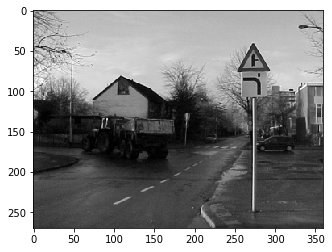

In [3]:
import matplotlib.cm as cm
grayimage = (0.3*im1[:,:,0]+0.6*im1[:,:,1]+0.1*im1[:,:,2])

imgplot = plt.imshow(grayimage,cmap=cm.gray)
#imgplot = plt.imshow(im1[:,:,0],cmap=cm.gray)

Consider using e.g. matplotlib.colors.rgb_to_hsv() to convert from RGB to HSV and use the V-channel in HSV. Display the V-component and get an opinion if it is better than the grayscale conversion you did above. Is the H or S component useful?

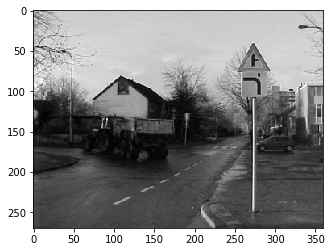

In [4]:
from matplotlib.colors import rgb_to_hsv
hsvim = rgb_to_hsv(im1)
imgplt=plt.imshow(hsvim[:,:,2],cmap=cm.gray)

## Apply edge detection using the Sobel operator to the image

Let us implement a Sobel operator using the ndimage package (or implement convolution from scratch).
Work on your selected grayscale image.
Compute the sobel magnitude image and display it. 


Since image convolution is a commutative operator, we can create a larger Sobel mask by first convolving the image with a smoothing filter (Gaussian or mean) of a given size, and then convolve this result with the Sobel. Try using mean filters of different size before the Sobel 


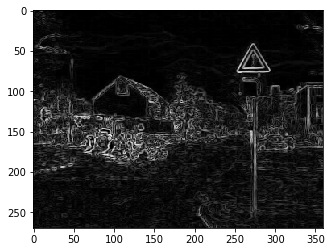

In [6]:
from scipy import ndimage
import numpy as np
from skimage import color
from skimage import filters

img = hsvim[:,:,1]
#img = grayimage

img = filters.gaussian(img, sigma=0.3)
gx = ndimage.sobel(img, 0)  # horizontal derivative
gy = ndimage.sobel(img, 1)  # vertical derivative
sobelmag = np.hypot(gx, gy)  # magnitude
sobelmag *= 255.0 / np.max(sobelmag)  # normalize (Q&D)
imgplt=plt.imshow(sobelmag,cmap = cm.gray)

Also try using the second order derivative/Laplacian (skimage.filters.laplace. What does the second order derivative give you with respect to edges? Try different filter sizes. How does it compare to Sobel?

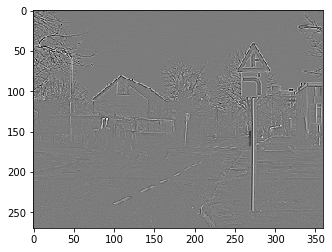

In [7]:
from skimage import filters
img = grayimage
#img = hsvim[:,:,1]*255
lapimg = filters.laplace(img,ksize=13)
#lapimg *= 255.0 / np.max(sobelmag)  # normalize (Q&D)
imgplt=plt.imshow(lapimg,cmap = cm.gray)

Think a bit. Is this result useful for segmentation? What is a good segmentation result? We are looking for a image where the traffic sign has a different value than the surroundings. If we get an image like this, we could use it to threshold to get potential areas.

The edge image contains a lot of line and perhaps also circles? Maybe we can use it to detect shapes like squares, triangles or circles later???

This segmentation is perhaps not as easy as we think.....


## Segmentation using thresholding

Let us try to use one of the grayscale channels as input to thresholding.



Note that if global thresholding should work, the image should ideally have a bimodal histrogram. Use matplotlib.hist to inspect the histogram of the image. Hint: use "imagename".ravel() convert to 1D.  



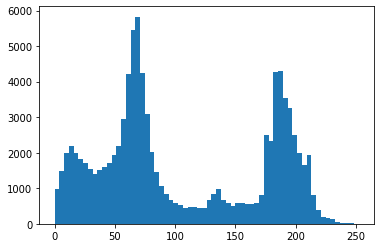

In [8]:
import cv2
#import numpy as np
#from matplotlib import pyplot as plt

plt.hist(grayimage.ravel(), bins=64)
plt.show()





Threshold found:  20


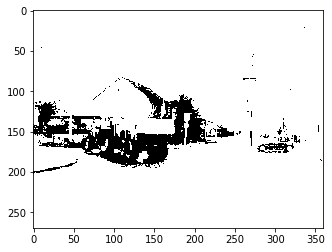

In [12]:
# Try various thresholding methods from skimage.filters
from skimage import filters
img = grayimage
#img = hsvim[:,:,1]*255
val = filters.threshold_otsu(img)
val=20
otsu_img = grayimage > val

print("Threshold found: ", val)

imgplt=plt.imshow(otsu_img,cmap = cm.gray)

### Try also adaptive thresholding

Consider trying adaptive thresholding (e.g. skimage.filter.threshold_local)  if global thresholding does not work.  Also experiment with using the graylevel image or one of the HSV-components as input. Try different window sizes in local thresholding. 


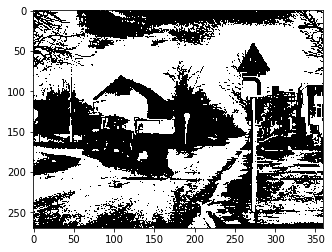

In [10]:
# Try various thresholding methods from skimage.filters
from skimage import filters
img = grayimage
#img = hsvim[:,:,2]*255

localth = img > filters.threshold_local(img, 75, 'mean')


imgplt=plt.imshow(localth,cmap = cm.gray)

## Summary of attempts

In this notebook we have explored simple color features and converted RGB image into HSV  or grayscale image to asses if they might be suitable for later processing to detect regions with traffic signs. 

We then explored edge detection in terms of Sobel magnitude.

Some simple thresholding method on the single-band images (graylevel or one of the RGB or HSV-components). 

The results are not impressing yet, and we need to learn more to be able to solve the region detection. 
